## Diamonds Data

In this project, we'll investigate the ability to predict the class (quality) of a diamond based on things like the cut geometries, shape, etc. We'll do this with a kNN algorithm for a binary classifier, as well as logistic regression for multi-classification.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder

## Read in the Diamonds data
This is data regarding 50,000 round cut diamonds.

|Factor            |Description                                                                                 |
|------------------|--------------------------------------------------------------------------------------------|
|price             |price in US dollars (326-18,823)                                                            |
|carat             |weight of the diamond (0.2--5.01)                                                           |
|cut               |quality of the cut (Fair, Good, Very Good, Premium, Ideal)                                  |
|color             |diamond colour, from J (worst) to D (best)                                                  |
|clarity           |how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))            |
|x                 |length in mm (0--10.74)                                                                     |
|y                 |width in mm (0--58.9)                                                                       |
|z                 |depth in mm (0--31.8)                                                                       |
|depth             |total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)                          |
|table             |width of top of diamond relative to widest point (43--95)                                   |

In [2]:
dia = pd.read_csv('./diamonds.csv')

## Explore the data

In [3]:
dia.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


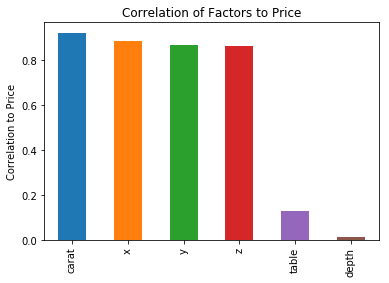

In [4]:
dia.corr()['price'].abs().sort_values(ascending=False).iloc[1:].plot(kind='bar')
plt.ylabel('Correlation to Price')
plt.title('Correlation of Factors to Price')
plt.show();

## Filter the Data
Filter the data to contain diamonds cuts of "Ideal" and "Good" only

In [5]:
dia.drop(index=dia[ ~dia['cut'].isin(['Ideal', 'Good']) ].index, inplace=True)

## Downsample the Majority Class

In [6]:
# We have a large class imbalance here, more than 4 to 1 in favor of 'Ideal'
# Since we have a fair number of samples, let's downsample our majority class
# instead of upsampling the minority class.
dia['cut'].value_counts()

Ideal    21551
Good      4906
Name: cut, dtype: int64

In [7]:
def balance_df(df, col_name):
    '''
    Downsamples an input dataframe
    to the minority class label frequency.
    
    Inputs:
    =======
    df : DataFrame, the full input dataframe
    col_name : string, the column label to be
    downsampled
    
    Outputs:
    ========
    DataFrame : copy of the original dataframe
    with col_name classes downsampled
    '''
    balanced_index = set([])
    for class_label in df[col_name].unique():
        balanced_index.update(
            resample(
                df[ df[col_name]==class_label],
                n_samples=df[col_name].value_counts()[-1],
                replace=False,
                random_state=1337).index
        )
    return df.loc[balanced_index, :]

In [8]:
# Note that we are passing a version of dia
# that ONLY has the 'Good' and 'Ideal' cut 
# values in it.
dia = balance_df(dia, 'cut')

In [9]:
dia['cut'].value_counts()

Good     4906
Ideal    4906
Name: cut, dtype: int64

## Prepare our X, y matrices
Let's construct an `X` matrix using **all numeric columns** from the diamond data.

We'll be predicting `cut`. Construct a `y` vector in a numeric format that can be used by scikit-learn.

In [10]:
X = dia.select_dtypes('number').astype('float64') # convert to float64 explicitly for StandardScaler
y = dia['cut']

## Scale the X matrix using a Standard Scaler

In [11]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

## Split Into Test and Train Groups

Now that we've downsampled/balanced our classes, as well as removed unused factors, we're ready to split into test and train groups. We're doing this avoid _leaking information into our test set_. 

- First, we'll perform cross-validation on our _train_ set, finding an optimial value for $k$. 
- After this, we'll take that value of $k$ and use it to fit our model to the _train_ set, creating our tuned model.
- Finally, we will take this same model and use it to _predict_ and _score_ against our _test_ set.
- Note that our model at this point will have never seen, nor trained against the _test_ set.

In the future, we can automate this process using a [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).

In [12]:
# Note that we use stratify=y to preserve our class label balance through the split
X_train, X_test, y_train, y_test = train_test_split(
    X_sc, y, test_size=0.3, random_state=1337, stratify=y)

In [13]:
y_train.value_counts()

Good     3434
Ideal    3434
Name: cut, dtype: int64

In [14]:
y_test.value_counts()

Good     1472
Ideal    1472
Name: cut, dtype: int64

## k-Nearest Neighbors
Let's fit a kNN model here, but first we need to tune our model to find the best value of $k$. Let's loop through values of $k$ we think are appropriate and select the value that produces the best model with respect to our **5-fold cross-validation**.

In [15]:
scores = {}
for k in range(1,101):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores[k] = cross_val_score(knn, X_train, y_train, cv=5).mean()

## Produce the plot of tuning parameter (k) vs Accuracy
What is the "best" value of k?

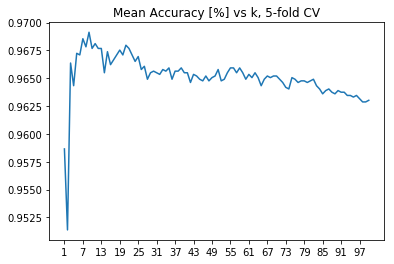

In [16]:
pd.Series(scores).plot()
plt.xticks(list(scores.keys())[::6])
plt.title('Mean Accuracy [%] vs k, 5-fold CV')
plt.show();

In [17]:
# It looks like k = 9 yields the greatest mean accuracy
pd.Series(scores).sort_values(ascending=False).head(3)

9     0.969133
7     0.968551
11    0.968113
dtype: float64

## Produce the Best kNN Model
Now that we know the optimal value of k, fit a kNN on the training set (this training set should still filtered to "Ideal" and "Good" cuts).

In [18]:
knn = KNeighborsClassifier(n_neighbors=pd.Series(scores).sort_values(ascending=False)[:1].index[0])
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=9, p=2,
           weights='uniform')

In [19]:
knn.get_params()['n_neighbors']

9

In [20]:
# Encode 'Good' and 'Ideal' to 0 and 1 respectively
# This is needed for the ROC/AUC functions as they
# don't work with string values. We'll store the
# encoded result in 'y_test_bl'.
le = LabelEncoder()
y_test_bl = le.fit_transform(y_test) # y_test binary labels

In [21]:
# And here's the result, joined to the original data to
# show the translation
pd.DataFrame(y_test_bl, columns=['encoded']).join(y_test.reset_index(drop=True)).head()

,encoded,cut
0,1,Ideal
1,1,Ideal
2,1,Ideal
3,1,Ideal
4,0,Good


In [22]:
le.classes_

array(['Good', 'Ideal'], dtype=object)

In [23]:
# Create sweeps of true and false positive rates
# First argument is the true binary class labels ('Good', 'Ideal')
# Second argument is the probability of a class '1' ('Good')
# predicted value, given the knn trained model
fpr, tpr, threshold = roc_curve(y_test_bl, knn.predict_proba(X_test)[:,1])

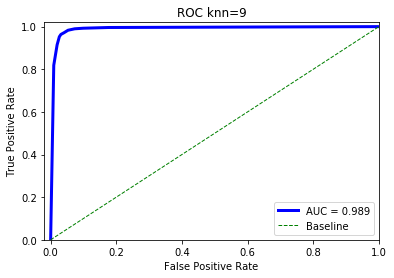

In [24]:
plt.title(f"ROC knn={knn.get_params()['n_neighbors']}")
plt.plot(fpr, tpr, 'b', label = f'AUC = {auc(fpr, tpr):0.3f}', lw=3)
# plot the baseline ROC curve
plt.plot([0, 1], [0, 1],'g--', lw=1, label='Baseline')
# give a little margin here on the chart
plt.xlim([-0.02, 1])
plt.ylim([0, 1.02])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show();

Here's our confusion matrix in the default orientation:

|-|-|
|---|---|
|TN | FP |
|FN | TP |

In [25]:
# Confusion matrix; predicted values on top (column)
# actual values on the side (index)
pd.DataFrame(confusion_matrix(y_test_bl,\
    le.transform(knn.predict(X_test)), labels=[0, 1]),\
    columns=le.classes_, index=le.classes_)

,Good,Ideal
Good,1412,60
Ideal,42,1430


And the same data in the inverted orientation:

|-|-|
|---|---|
|TP | FN |
|FP | TN |

In [26]:
# Confusion matrix; predicted values on top (column)
# actual values on the side (index)
pd.DataFrame(confusion_matrix(y_test_bl, \
    le.transform(knn.predict(X_test)), labels=[1, 0]), \
    columns=le.classes_[::-1], index=le.classes_[::-1])

,Ideal,Good
Ideal,1430,42
Good,60,1412


## Does this model outperform the baseline?

In [27]:
# Build a model that always predicts the majority class
# Train it full train set, and test it on the test set
# Note that both sets are perfectly class balanced, so this
# should be 50%.
print(f"Baseline accuracy is \
{DummyClassifier(strategy='most_frequent').fit(X_train, y_train).score(X_test, y_test)*100:.1f}% \
on our test set.")

Baseline accuracy is 50.0% on our test set.


In [28]:
print(f"Knn of {knn.get_params()['n_neighbors']} neighbors yields \
an accuracy of {knn.score(X_test, y_test)*100:.1f}% on our test set.")

Knn of 9 neighbors yields an accuracy of 96.5% on our test set.


## Prediction
Suppose I have a diamond with the following specifications:

In [29]:
new_diamond = pd.DataFrame({
    'carat': 0.24,
    'depth': 60.,
    'table': 64.,
    'price': 400.,
    'x': 3.,
    'y': 3.,
    'z': 3.
}, index=[0])

What do we predict the cut of this diamond to be?

In [30]:
knn.predict(sc.transform(new_diamond))

array(['Good'], dtype=object)

The new diamond is probably of cut quality "Good".

# Logistic Regression on all the Cut Classes

Using the _full_ diamonds data set, let's produce a **logistic regression** model that achieves the best 5-fold cross validation. Note that for this problem, we are doing multi-class classification. The response variable has _five_ categories.

In [31]:
# Let's read in the data and overwrite any previous
# dataframes.

dia = pd.read_csv('./diamonds.csv')

In [32]:
# Here we are re-using the balance_df function we wrote before.
# We could optionally upsample our minority classes to help strike
# a balance between generating data and 'destroying' data, but we've
# elected to downsample to keep the data small and fast for training.

dia = balance_df(dia, 'cut')

In [33]:
# Here we can see that our majority classes have all 'come down'
# to meet the number of samples for our 'lowest common denominator'
# minority class, which has 1,610 samples.

dia['cut'].value_counts()

Premium      1610
Good         1610
Fair         1610
Ideal        1610
Very Good    1610
Name: cut, dtype: int64

In [34]:
# Here we are creating an array of floats for our
# X array, and two copies of our y. One y is the 
# string representation of our classes, and y_bl
# is the label-encoded version of our string classes.
# This is needed for confusion matricies as well as
# more sophisticated practices. We can convert to and 
# from these label encodings using the .transform() 
# and .inverse_transform() methods.

X = dia.select_dtypes('number').astype('float64') # convert to float64 explicitly for StandardScaler
y = dia['cut']
le = LabelEncoder()
y_bl = le.fit_transform(y)

In [35]:
le.classes_

array(['Fair', 'Good', 'Ideal', 'Premium', 'Very Good'], dtype=object)

In [36]:
# Scale all X factors, note we are
# storing the scaling object in 'sc'. 
# This can be used on future data to scale
# it as well.

sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [37]:
# We're using the same technique as before here, reserving
# our testing data for testing only, never exposing it to 
# our cross-validation. Note how we are scaling and encoding
# our X and y arrays prior to this step. This is a luxury
# we have available to us because we have both testing and 
# training data at this time. In the future, we will need
# fault tolerant processing steps to handle data we 
# haven't seen before which may not match data we've 
# trained againse previously. Note that we are preserving
# our class balance with the 'stratify' kwarg.

X_train, X_test, y_train, y_test = train_test_split(
    X_sc, y_bl, test_size=0.3, random_state=1337, stratify=y_bl)

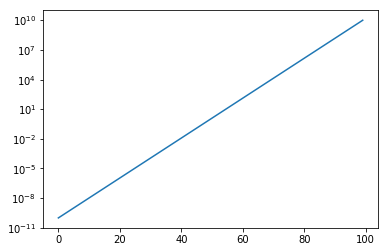

In [38]:
# Before we start tuning, we'll need to set up a
# parameter space to sweep over when we tune our
# hyperparameter, C. We've selected a log space
# here to cover more ground, and charted the result
# on a log plot to give an idea of the space
# we are covering. The goal is to set a space fairly
# wide, and converge onto a (hopefully) global min
# or max as an optimal value.

pd.Series(np.logspace(-10,10,num=100)).plot()
plt.yscale('log')
plt.show();

In [39]:
# Here we are using a randomized search to tune our
# hyperparameters. This is similar to a grid search,
# only we set up the bounds of values we'd like to 
# search over, and the model randomly selects from 
# those values. We will be tuning the value of C, 
# which is the regularization parameter. We have
# 100 values to select from, and we'll be sampling 10
# of them to help save training time.

rs = RandomizedSearchCV(
    LogisticRegression(solver='lbfgs', class_weight='balanced', multi_class='ovr'),
    {'C': np.logspace(-10,10,num=100)},
    cv=5,
    n_iter=len(np.logspace(-10,10,num=100))/10 # sample 1/10th of the total C's
)

In [40]:
# This is where we fit out model to the training data.
# Note that our RandomizedSearchCV takes care of 
# cross-validation for us, as well as trying different
# hyperparameter values for C. The scoring metric will be
# evaluated, and a 'best model' object will be placed into the
# .best_estimator_ class attribute, pre-configured
# with the hyperparameters that yielded the highest score
# during our training step.
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10.0, n_jobs=None,
          param_distributions={'C': array([1.00000e-10, 1.59228e-10, ..., 6.28029e+09, 1.00000e+10])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [41]:
# Here we can see the value of C (inverse regularization parameter)
# that our random search selected. Smaller values imply more
# regularization of our fitting coefficients.
rs.best_estimator_.C

2477076355.991714

In [42]:
# This is an interesting table, the join between four tables:
# 1) The original X_test feature table
# 2) The log probability returned for each of the classes 
# from our model
# 3) The ACTUAL predicted value (Pred), which is the max
# of the log probabilities of the classes.
# 4) A new column 'Actual', which is just a copy of the 
# original 'cut' column, placed on the end for clarity.
# Note how our 'Pred' column (predicted value) doesn't
# always match our 'cut' column (actual value), however
# our log probabilities (columns 'Fair' through 'Very Good')
# inclusive give us the likelihood of a class, which is helpful
# to gauge the certainty of our classification.

dia.reset_index(drop=True).join(
    pd.DataFrame(rs.best_estimator_.predict_log_proba(X_test),
                 columns=le.classes_)
).join(
    pd.DataFrame(le.inverse_transform(rs.best_estimator_.predict(X_test)),
                 columns=['Pred'])
).join(
    pd.DataFrame(dia['cut'].reset_index(drop=True).values, columns=['Actual'])
).head()

,carat,cut,color,clarity,depth,table,price,x,y,z,Fair,Good,Ideal,Premium,Very Good,Pred,Actual
0,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,-2.322687,-1.173046,-3.713865,-1.313604,-1.206193,Good,Premium
1,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,-1.729270,-2.144315,-1.521210,-0.999231,-2.130077,Premium,Good
2,0.34,Ideal,D,SI1,62.0,56.0,803,4.50,4.47,2.78,-0.895668,-1.461680,-5.164644,-1.413503,-2.199901,Fair,Ideal
3,0.34,Premium,D,SI1,62.4,58.0,803,4.46,4.42,2.77,-1.654534,-1.592352,-3.322770,-0.986658,-1.627098,Premium,Premium
4,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49,-2.525573,-1.338947,-1.126940,-2.756383,-1.308142,Ideal,Fair


In [43]:
# Finally, we can see our confusion matrix. Note that this
# is a multi-class confusion matrix, so we'll have n x n factors.
# We could optionally chart our our binary class prediction values
# with a ROC/AUC chart as we did previously, if we used a OvR
# (one versus rest) strategy.
# We can see that we have quite a few samples that were predicted
# as 'Ideal' but were in reality 'Very Good'.

pd.DataFrame(confusion_matrix(y_test, \
    rs.best_estimator_.predict(X_test)),\
    columns=le.classes_, index=le.classes_)

,Fair,Good,Ideal,Premium,Very Good
Fair,333,41,25,73,11
Good,90,156,93,57,87
Ideal,12,6,349,47,69
Premium,70,31,46,268,68
Very Good,32,92,147,40,172
